In [12]:
# =============================================
# STEP 1 — LOAD TRAINING + TESTING FROM GITHUB
# =============================================

import pandas as pd

train_url = "https://raw.githubusercontent.com/CollinsKarani/UNSW-NB15/main/UNSW_NB15_training-set.csv"
test_url  = "https://raw.githubusercontent.com/CollinsKarani/UNSW-NB15/main/UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_url)
df_test  = pd.read_csv(test_url)

print("Training shape:", df_train.shape)
print("Testing shape:", df_test.shape)

df_train.head()


Training shape: (175341, 45)
Testing shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Inspect and Identify Columns

In [13]:
df_train.columns


Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [52]:
df_test.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

Remove Non-Predictive Columns

In [14]:
irrelevant = ["id"]
df_train = df_train.drop(columns=irrelevant, errors="ignore")
df_test  = df_test.drop(columns=irrelevant, errors="ignore")

Handle Missing Values

In [15]:
print(df_train.isna().sum().sum(), "missing values in train")
print(df_test.isna().sum().sum(),  "missing values in test")

df_train = df_train.dropna()
df_test  = df_test.dropna()

0 missing values in train
0 missing values in test


Encode Categorical Features

In [53]:
# List of categorical columns that require label encoding
categorical_cols = ["proto", "service", "state", "attack_cat"]

In [54]:
# Encode categorical columns without leakage:
# fit on training data only, map unseen test categories to "unknown",
# and ensure both sets share the same encoding.

from sklearn.preprocessing import LabelEncoder

categorical_cols = ["proto", "service", "state", "attack_cat"]

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Fit ONLY on train set
    le.fit(df_train[col].astype(str))

    # Map unseen categories in TEST to "unknown"
    train_classes = set(le.classes_)
    df_test[col] = df_test[col].astype(str).apply(
        lambda x: x if x in train_classes else "unknown"
    )

    # Add "unknown" to the encoder classes if needed
    if "unknown" not in le.classes_:
        le.classes_ = np.append(le.classes_, "unknown")

    # Transform
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col]  = le.transform(df_test[col].astype(str))

    encoders[col] = le

Split Features + Labels

In [19]:
# Define the target column for prediction
target_col = "label"

In [33]:

target_col = "label"

# REMOVE BOTH label AND attack_cat before training since attack_cat directly reveals whether traffic is normal or malicious
X_train = df_train.drop(columns=[target_col, "attack_cat"], errors="ignore")
y_train = df_train[target_col]

X_test  = df_test.drop(columns=[target_col, "attack_cat"], errors="ignore")
y_test  = df_test[target_col]

In [45]:
'attack_cat' in X_train.columns

# ============================================================
# SAFETY CHECK: Ensure "attack_cat" is NOT inside X_train.
# Leaving this column in the feature set causes severe
# DATA LEAKAGE because "attack_cat" directly determines "label".
# ============================================================


False

In [59]:
# Sanity check: ensure "label" is not mistakenly included in the feature set

[label for label in X_train.columns if label == "label"]


[]

In [46]:
X_train.columns[-5:]

# ------------------------------------------------------------
# Quick inspection of the last few feature columns.
# This is used to verify that no forbidden columns such as
# "attack_cat" or "label" accidentally remained inside X_train.
# ------------------------------------------------------------


Index(['ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst',
       'is_sm_ips_ports'],
      dtype='object')

In [47]:
# Check train/test split sizes to ensure correct dataset loading
df_train.shape, df_test.shape


((175341, 44), (82332, 44))

In [48]:
# Verify the class distribution in the test labels (sanity check)
df_test['label'].value_counts()

,count
label,
1,45332
0,37000


Mutual Information Feature Selection

Top MI features: ['sbytes', 'sttl', 'dbytes', 'ct_state_ttl', 'dttl', 'rate', 'sload', 'dur', 'smean', 'dmean', 'dinpkt', 'dload', 'dpkts', 'sinpkt', 'tcprtt']


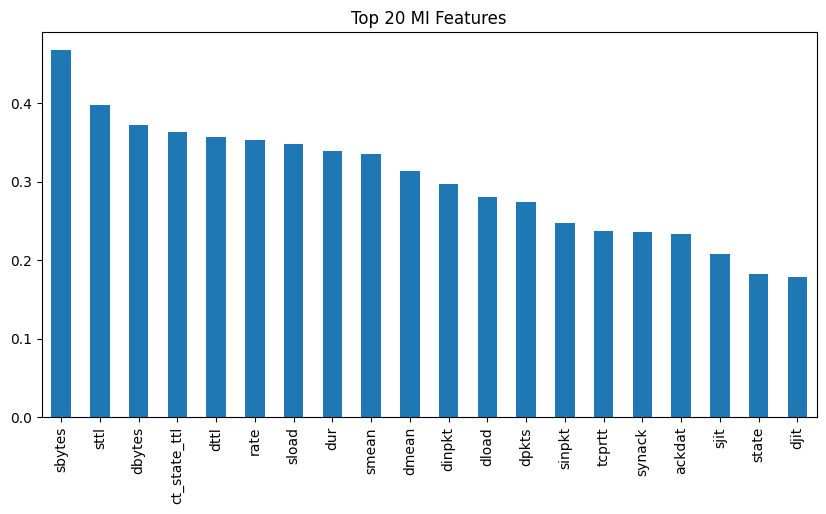

In [35]:
# ------------------------------------------------------------
# Compute Mutual Information (MI) to measure how strongly each
# feature is related to the target label. MI captures both linear
# and non-linear relationships, making it ideal for UNSW-NB15.
# We then rank features by MI score and select the top K most
# informative features for the ML models.
# ------------------------------------------------------------

from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

top_features = mi.head(15).index.tolist()

print("Top MI features:", top_features)

mi.head(20).plot(kind='bar', figsize=(10,5))
plt.title("Top 20 MI Features")
plt.show()

X_train_sel = X_train[top_features]
X_test_sel  = X_test[top_features]

Scale Features

In [36]:
# ------------------------------------------------------------
# Standardize the selected features so all models receive data
# on the same scale. This is essential for distance-based models
# like KNN and helps improve stability for Logistic Regression.
# ------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

RANDOM FOREST Classifier


=== Random Forest Results ===
Accuracy:  0.8686051595977263
Precision: 0.8220310517279988
Recall:    0.9717418159357628
F1 Score:  0.8906389001213102


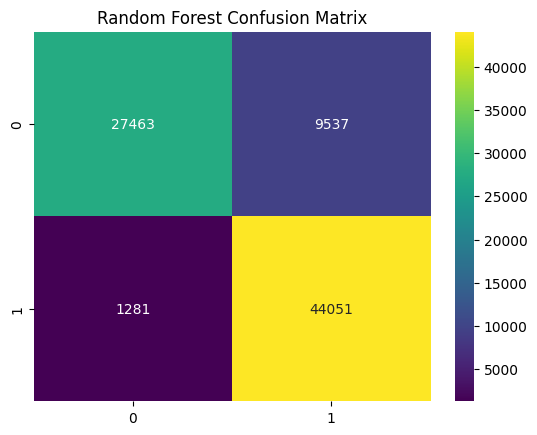

In [37]:
# ============================
# RANDOM FOREST CLASSIFIER
# ============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("\n=== Random Forest Results ===")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:   ", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score: ", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Random Forest Confusion Matrix")
plt.show()

DECISION TREE Classifier


=== Decision Tree Results ===
Accuracy:  0.8629937326920274
Precision: 0.8239468777350736
Recall:    0.9552854495720462
F1 Score:  0.884768617836347


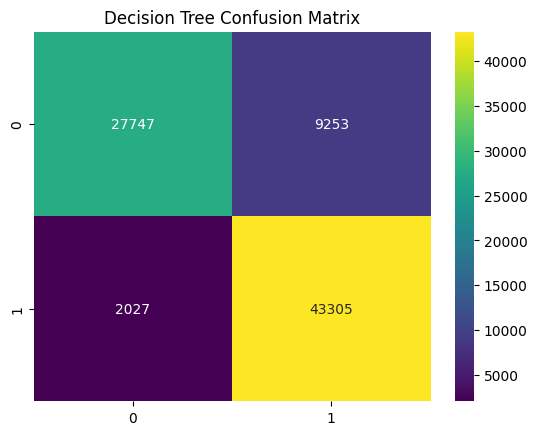

In [38]:
# ============================
# DECISION TREE CLASSIFIER
# ============================

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

print("\n=== Decision Tree Results ===")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:   ", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score: ", f1_score(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Decision Tree Confusion Matrix")
plt.show()

KNN Classifier


=== KNN Results ===
Accuracy:   0.8695646893067094
Precision:  0.8323118599780975
Recall:     0.955638401129445
F1 Score:   0.8897218143169612


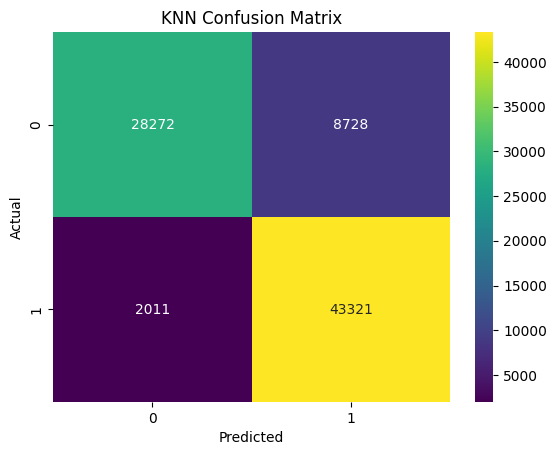

In [50]:
# ============================
# K-NEAREST NEIGHBORS (KNN)
# ============================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize model
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)

# Metrics
print("\n=== KNN Results ===")
print("Accuracy:  ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, zero_division=0))
print("Recall:    ", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:  ", f1_score(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Logistic Regression Classifier


=== Logistic Regression Results ===
Accuracy:   0.7704902103677792
Precision:  0.709457103920388
Recall:     0.9876246360187064
F1 Score:   0.8257437429683321


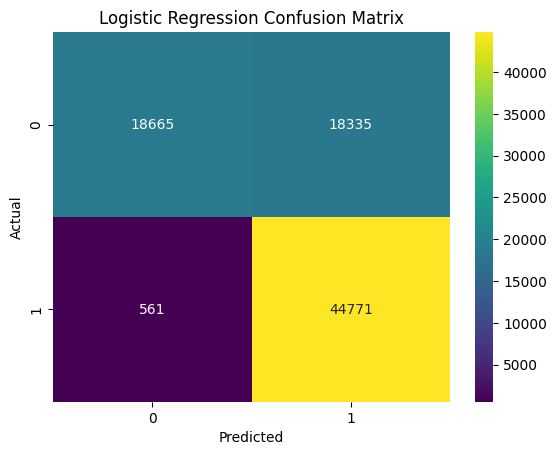

In [51]:
# ============================
# LOGISTIC REGRESSION
# ============================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize model
lr = LogisticRegression(max_iter=2000)

# Train
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

# Metrics
print("\n=== Logistic Regression Results ===")
print("Accuracy:  ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, zero_division=0))
print("Recall:    ", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:  ", f1_score(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
